In [1]:
using Revise

In [2]:
using ViscousFlow

In [3]:
using LinearAlgebra

In [82]:
using Plots
pyplot()
clibrary(:colorbrewer)
default(grid = false)

┌ Info: Recompiling stale cache file /Users/jeff/.julia/compiled/v1.2/Plots/ld3vC.ji for Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
└ @ Base loading.jl:1240
┌ Info: Recompiling stale cache file /Users/jeff/.julia/compiled/v1.2/PyPlot/oatAj.ji for PyPlot [d330b81b-6aea-500a-939a-2ce795aea3ee]
└ @ Base loading.jl:1240
┌ Warning: /Users/jeff/.julia/packages/Plots/RsO3g/src/Plots.jl/ is not an existing directory, Revise is not watching
└ @ Revise /Users/jeff/.julia/packages/Revise/C272c/src/Revise.jl:491


In [63]:
using Pkg
pkg"test ViscousFlow"

  Updating registry at `~/.julia/registries/General`
  Updating git-repo `https://github.com/JuliaRegistries/General.git`
   Testing ViscousFlow
 Resolving package versions...
Test Summary:        | Pass  Total
Saddle-Point Systems |   26     26
   Testing ViscousFlow tests passed 


In [43]:
?SaddleSystem

search: SaddleSystem SaddlePointSystems



```
SaddleSystem
```

Construct a saddle-point system operator from the constituent operator blocks. The resulting object can be used with `*` and `` to multiply and solve. The saddle-point problem has the form

$\begin{bmatrix}A & B_1^T \\ B_2 & C \end{bmatrix} \begin{pmatrix} u \\ f \end{pmatrix} = \begin{pmatrix} r_1 \\ r_2 \end{pmatrix}$

### Constructors

`SaddleSystem(A::AbstractMatrix,B₂::AbstractMatrix,B₁ᵀ::AbstractMatrix,C::AbstractMatrix[,eltype=Float64])`. Blocks are given as matrices. Must have consistent sizes to stack appropriately. If this is called with `SaddleSystem(A,B₂,B₁ᵀ)`, it sets `C` to zero automatically.

`SaddleSystem(A,B₂,B₁ᵀ,C,u,f[,eltype=Float64])`. Operators `A`, `B₂`, `B₁ᵀ`, `C` are given in various forms, including matrices, functions, and function-like objects. `u` and `f` are examples of the data types in the corresponding solution and right-hand side vectors. Guidelines:

  * The entries `A` and `B₂` must be able to act upon `u` (either by multiplication or as a function) and `B₁ᵀ` and `C` must be able to act on `f` (also, either by multiplication or as a function).
  * `A` and `B₁ᵀ` should return data of type `u`, and `B₂` and `C` should return data of type `f`.
  * `A` must be invertible and be outfitted with operators ``and`ldiv!`.
  * Both `u` and `f` must be mappable to/from `AbstractVector` type. This essentially means that they should be subtypes of `AbstractArray`.

If called as `SaddleSystem(A,B₂,B₁ᵀ,u,f)`, the `C` block is omitted and assumed to be zero.

If called with `SaddleSystem(A,u)`, this is equivalent to calling `SaddleSystem(A,nothing,nothing,u,[])`, then this reverts to the unconstrained system described by operator `A`.


### Test on matrices

In [19]:
A1 = Float64[1 2; 2 1]
B2 = Float64[2 3;-1 -1]
B1 = Float64[2 3;-1 -1]'
C = Matrix{Float64}(undef,2,2)
C.= [5 -2; 3 -4];

In [20]:
A = SaddleSystem(A1,B2,B1,C)

Saddle system with 2 states and 2 constraints and
   State vector of type Array{Float64,1}
   Constraint vector of type Array{Float64,1}
   Elements of type Float64


In [21]:
rhs = ([1.0,2.0],[3.0,4.0]);
sol = (zeros(2),zeros(2));

In [25]:
@time ldiv!(sol,A,rhs)

  0.000031 seconds (20 allocations: 912 bytes)


([-4.440892098500626e-16, -0.35714285714285704], [0.6428571428571431, -0.42857142857142827])

In [27]:
@time sol2 = A\rhs

  0.000035 seconds (23 allocations: 1.109 KiB)


([-4.440892098500626e-16, -0.35714285714285704], [0.6428571428571431, -0.42857142857142827])

#### Test with vector inputs/outputs

In [28]:
rhs1, rhs2 = rhs
rhsvec = [rhs1;rhs2]
solvec = similar(rhsvec);

In [29]:
solvec = A\rhsvec;

In [30]:
A*solvec

4-element Array{Float64,1}:
 0.9999999999999999
 1.9999999999999998
 3.0               
 4.0               

### Test on ViscousFlow operators

In [4]:
nx = 130; ny = 130;
Lx = 2.0;
dx = Lx/(nx-2);
w = Nodes(Dual,(nx,ny));
u = similar(w);

In [5]:
wvec = vec(w);

In [6]:
L = plan_laplacian(size(w),with_inverse=true)

Discrete Laplacian (and inverse) on a (nx = 130, ny = 130) grid acting on Float64 data with spacing 1.0

In [7]:
w .= rand(size(w)...);

In [8]:
n = 128;
θ = range(0,stop=2π,length=n+1);
R = 0.5;
xb = 1.0 .+ R*cos.(θ[1:n])
yb = 1.0 .+ R*sin.(θ[1:n])
ds = (2π/n)*R;
X = VectorData(xb,yb);
f = ScalarData(X);

In [17]:
E = Regularize(X,dx;issymmetric=true)
Hmat,Emat = RegularizationMatrix(E,f,w);

In [36]:
@time A = SaddleSystem(L,Emat,Hmat,w,f)

  3.106903 seconds (3.68 k allocations: 67.339 MiB, 0.39% gc time)


Saddle system with 16900 states and 128 constraints and
   State vector of type Nodes{Dual,130,130,Float64}
   Constraint vector of type ScalarData{128,Float64}
   Elements of type Float64


In [37]:
ψb = ScalarData(X);
w = Nodes(Dual,(nx,ny));
ψb .= -(xb .- 1);
f .= ones(Float64,n)*ds;
ψ = Nodes(Dual,w);

In [38]:
sol2 = (zero(w),zero(f));
@time ldiv!(sol2,A,(w,ψb));

  0.817966 seconds (2.65 M allocations: 128.645 MiB, 15.33% gc time)


In [40]:
@time ψ,f = A\(w,ψb);

  0.002233 seconds (53 allocations: 797.344 KiB)


In [41]:
sol2[1]==ψ

true

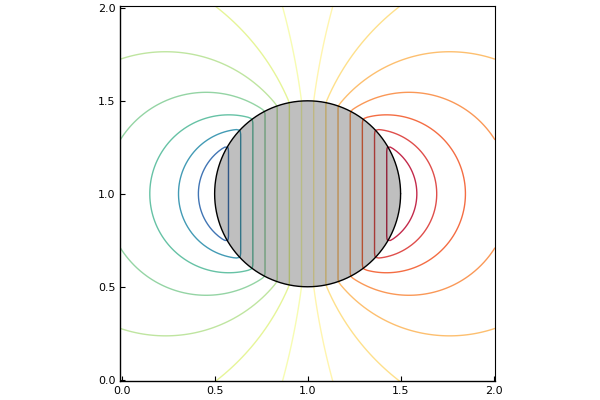

In [29]:
xg,yg = coordinates(ψ,dx=dx)
plot(xg,yg,ψ)
plot!(xb,yb,xlim=(-Inf,Inf),ylim=(-Inf,Inf),fillcolor=:black,fillrange=0,fillalpha=0.25,linecolor=:black)

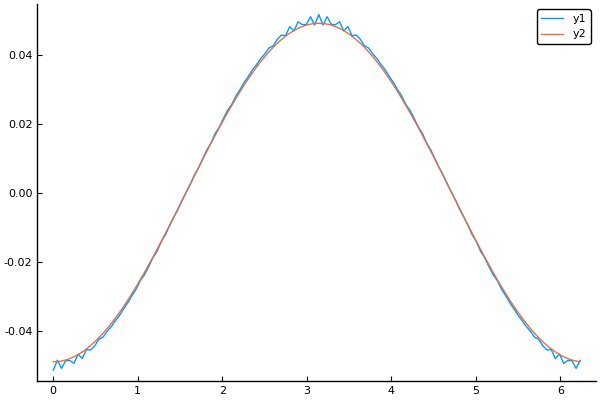

In [99]:
plot(θ[1:n],f)
plot!(θ[1:n],-2*cos.(θ[1:n])*ds)

In [42]:
norm(f+2*cos.(θ[1:n])*ds)

0.010176487612409175

### ViscousFlow with integrating factor operator

In [11]:
Δt = 1.0
H = plan_intfact(Δt,w);

In [13]:
struct IFOperator
    op :: ViscousFlow.Fields.IntFact
end

In [14]:
import Base: \, *

In [15]:
\(A::IFOperator,w::Nodes) = A.op*w;
*(A::IFOperator,w::Nodes) = w;

In [18]:
A = SaddleSystem(IFOperator(H),Emat,Hmat,w,f)

Saddle system with 16900 states and 128 constraints and
   State vector of type Nodes{Dual,130,130,Float64}
   Constraint vector of type ScalarData{128,Float64}
   Elements of type Float64


In [85]:
ψb = ScalarData(X);
w = Nodes(Dual,(nx,ny));
ψb .= -(xb .- 1).*(yb .- 1);
f .= ones(Float64,n)*ds;
ψ = Nodes(Dual,w);
@time ψ,f = A\(w,ψb);

  0.002288 seconds (53 allocations: 797.344 KiB)


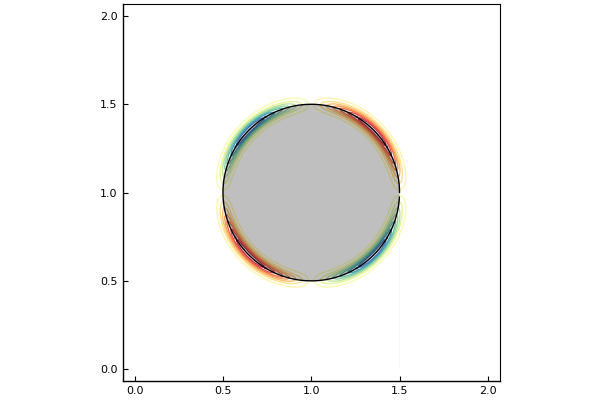

In [83]:
xg,yg = coordinates(ψ,dx=dx)
plot(xg,yg,ψ)
plot!(xb,yb,fillcolor=:black,fillrange=0,fillalpha=0.25,linecolor=:black)

### ViscousFlow with vector force data

In [19]:
fv = VectorData(X);
q = Edges(Primal,w);

In [20]:
E = Regularize(X,dx;issymmetric=true)
Hvmat,Evmat = RegularizationMatrix(E,fv,q);

In [21]:
B₁ᵀ(f) = Curl()*(Hvmat*f);

In [22]:
B₂(w) = -(Evmat*(Curl()*(L\w)))

B₂ (generic function with 1 method)

In [64]:
Aop = SaddlePointSystems.linear_map(IFOperator(H),w);

In [76]:
Ainvop = SaddlePointSystems.linear_inverse_map(IFOperator(H),w);

In [83]:
AB = Ainvop*B1op

LinearMaps.CompositeMap{Float64,Tuple{LinearMaps.FunctionMap{Float64,getfield(ViscousFlow.SaddlePointSystems, Symbol("##60#61")){typeof(B₁ᵀ),VectorData{128,Float64}},Nothing},LinearMaps.FunctionMap{Float64,getfield(ViscousFlow.SaddlePointSystems, Symbol("##62#63")){IFOperator,Nodes{Dual,130,130,Float64}},Nothing}}}((LinearMaps.FunctionMap{Float64}(#60, 16900, 256; ismutating=false, issymmetric=false, ishermitian=false, isposdef=false), LinearMaps.FunctionMap{Float64}(#62, 16900, 16900; ismutating=false, issymmetric=false, ishermitian=false, isposdef=false)))

In [84]:
AB*SaddlePointSystems._unwrap_vec(fv)

DimensionMismatch: DimensionMismatch("mul!")

In [86]:
size(SaddlePointSystems._unwrap_vec(fv))

(256,)

In [65]:
B1op = SaddlePointSystems.linear_map(B₁ᵀ,fv,w);

In [66]:
B2op = SaddlePointSystems.linear_map(B₂,w,fv);

In [95]:
S = -B2op*Ainvop*B1op;

In [101]:
using LinearMaps

In [102]:
S = LinearMap{Float64}(x -> B2op*(Ainvop*(B1op*x)),length(fv));

In [99]:
B2op*(Ainvop*(B1op*SaddlePointSystems._unwrap_vec(fv)))

([-0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0  …  -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0], [-0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0  …  -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0])

In [103]:
S*SaddlePointSystems._unwrap_vec(fv)

([-0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0  …  -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0], [-0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0  …  -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0])

In [105]:
typeof(fv.u)

ScalarData{128,Float64}

In [4]:
struct NewScalarDataCollection{N,T}
    data :: AbstractVector{T}
    u :: NewScalarData
    v :: NewScalarData
end

In [2]:
struct NewScalarData{N,T}
    data :: AbstractVector{T}
end

In [7]:
data = zeros(256);

In [5]:
function NewScalarData(data::AbstractVector{T}) where {T <: Number}
  NewScalarData{length(data),T}(data)
end

NewScalarData

In [118]:
sdata = zeros(128);

In [119]:
@time ScalarData(sdata);

  0.000010 seconds (5 allocations: 176 bytes)


In [127]:
@time NewScalarData(view(data,1:128))

  0.000010 seconds (7 allocations: 256 bytes)


NewScalarData{128,Float64}([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])

In [137]:
NewScalarData(view(data,div(length(data),2)+1:length(data)))

NewScalarData{128,Float64}([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])

In [6]:
function NewScalarDataCollection(data::AbstractVector{T}) where {T <: Number}
  u = NewScalarData(view(data,1:div(length(data),2)))
  v = NewScalarData(view(data,div(length(data),2)+1:length(data)))
  return NewScalarDataCollection{length(data),T}(data,u,v)
end

NewScalarDataCollection

In [11]:
@time v = NewScalarDataCollection(data);

  0.000008 seconds (10 allocations: 368 bytes)


In [14]:
v.u.data[5] = 1.0;

In [15]:
v

NewScalarDataCollection{256,Float64}([0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], NewScalarData{128,Float64}([0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]), NewScalarData{128,Float64}([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]))

In [39]:
using RecursiveArrayTools

In [41]:
@time fvp = ArrayPartition(fv.u,fv.v);

  0.000015 seconds (7 allocations: 256 bytes)


In [48]:
typeof(fvp)

ArrayPartition{Float64,Tuple{ScalarData{128,Float64},ScalarData{128,Float64}}}

In [45]:
@time f2 = VectorData(fvp.x[1],fvp.x[2]);

  0.000011 seconds (6 allocations: 240 bytes)


In [52]:
SaddlePointSystems._unwrap_vec(fv::VectorData) = ArrayPartition(fv.u,fv.v)
SaddlePointSystems._wrap_vec(v::ArrayPartition,u::VectorData) = VectorData(v.x[1],v.x[2])

In [153]:
Aop = LinearMap{Float64}(IFOperator(H),length(w));

ArgumentError: ArgumentError: collection must be non-empty

In [149]:
B2op = LinearMap{Float64}(fcn,length(fv),length(w));

In [140]:
import Base: vec

In [141]:
vec(f::VectorData{N}) where {N} = [f.u;f.v];

In [ ]:
B2op*IFOperator(H)

In [151]:
B2op*vec(w)

256-element Array{Float64,1}:
 -0.0
 -0.0
 -0.0
 -0.0
 -0.0
 -0.0
 -0.0
 -0.0
 -0.0
 -0.0
 -0.0
 -0.0
 -0.0
  ⋮  
 -0.0
 -0.0
 -0.0
 -0.0
 -0.0
 -0.0
 -0.0
 -0.0
 -0.0
 -0.0
 -0.0
 -0.0

In [27]:
SaddleSystem(IFOperator(H),B₂,B₁ᵀ,w,fv)

MethodError: MethodError: no method matching *(::Curl, ::Array{Float64,1})
Closest candidates are:
  *(::Any, ::Any, !Matched::Any, !Matched::Any...) at operators.jl:529
  *(::Curl, !Matched::Union{Edges{Primal,NX,NY,T} where T<:Number, Nodes{Dual,NX,NY,T} where T<:Number}) where {NX, NY} at /Users/jeff/JuliaProjects/ViscousFlow/src/fields/diffcalculus.jl:101
  *(!Matched::Adjoint{#s617,#s616} where #s616<:Union{DenseArray{T<:Union{Complex{Float32}, Complex{Float64}, Float32, Float64},2}, Base.ReinterpretArray{T<:Union{Complex{Float32}, Complex{Float64}, Float32, Float64},2,S,A} where S where A<:Union{SubArray{T,N,A,I,true} where I<:Union{Tuple{Vararg{Real,N} where N}, Tuple{AbstractUnitRange,Vararg{Any,N} where N}} where A<:DenseArray where N where T, DenseArray}, Base.ReshapedArray{T<:Union{Complex{Float32}, Complex{Float64}, Float32, Float64},2,A,MI} where MI<:Tuple{Vararg{Base.MultiplicativeInverses.SignedMultiplicativeInverse{Int64},N} where N} where A<:Union{Base.ReinterpretArray{T,N,S,A} where S where A<:Union{SubArray{T,N,A,I,true} where I<:Union{Tuple{Vararg{Real,N} where N}, Tuple{AbstractUnitRange,Vararg{Any,N} where N}} where A<:DenseArray where N where T, DenseArray} where N where T, SubArray{T,N,A,I,true} where I<:Union{Tuple{Vararg{Real,N} where N}, Tuple{AbstractUnitRange,Vararg{Any,N} where N}} where A<:DenseArray where N where T, DenseArray}, SubArray{T<:Union{Complex{Float32}, Complex{Float64}, Float32, Float64},2,A,I,L} where L where I<:Tuple{Vararg{Union{Int64, AbstractRange{Int64}, Base.AbstractCartesianIndex},N} where N} where A<:Union{Base.ReinterpretArray{T,N,S,A} where S where A<:Union{SubArray{T,N,A,I,true} where I<:Union{Tuple{Vararg{Real,N} where N}, Tuple{AbstractUnitRange,Vararg{Any,N} where N}} where A<:DenseArray where N where T, DenseArray} where N where T, Base.ReshapedArray{T,N,A,MI} where MI<:Tuple{Vararg{Base.MultiplicativeInverses.SignedMultiplicativeInverse{Int64},N} where N} where A<:Union{Base.ReinterpretArray{T,N,S,A} where S where A<:Union{SubArray{T,N,A,I,true} where I<:Union{Tuple{Vararg{Real,N} where N}, Tuple{AbstractUnitRange,Vararg{Any,N} where N}} where A<:DenseArray where N where T, DenseArray} where N where T, SubArray{T,N,A,I,true} where I<:Union{Tuple{Vararg{Real,N} where N}, Tuple{AbstractUnitRange,Vararg{Any,N} where N}} where A<:DenseArray where N where T, DenseArray} where N where T, DenseArray}} where #s617, ::Union{DenseArray{S,1}, Base.ReinterpretArray{S,1,S,A} where S where A<:Union{SubArray{T,N,A,I,true} where I<:Union{Tuple{Vararg{Real,N} where N}, Tuple{AbstractUnitRange,Vararg{Any,N} where N}} where A<:DenseArray where N where T, DenseArray}, Base.ReshapedArray{S,1,A,MI} where MI<:Tuple{Vararg{Base.MultiplicativeInverses.SignedMultiplicativeInverse{Int64},N} where N} where A<:Union{Base.ReinterpretArray{T,N,S,A} where S where A<:Union{SubArray{T,N,A,I,true} where I<:Union{Tuple{Vararg{Real,N} where N}, Tuple{AbstractUnitRange,Vararg{Any,N} where N}} where A<:DenseArray where N where T, DenseArray} where N where T, SubArray{T,N,A,I,true} where I<:Union{Tuple{Vararg{Real,N} where N}, Tuple{AbstractUnitRange,Vararg{Any,N} where N}} where A<:DenseArray where N where T, DenseArray}, SubArray{S,1,A,I,L} where L where I<:Tuple{Vararg{Union{Int64, AbstractRange{Int64}, Base.AbstractCartesianIndex},N} where N} where A<:Union{Base.ReinterpretArray{T,N,S,A} where S where A<:Union{SubArray{T,N,A,I,true} where I<:Union{Tuple{Vararg{Real,N} where N}, Tuple{AbstractUnitRange,Vararg{Any,N} where N}} where A<:DenseArray where N where T, DenseArray} where N where T, Base.ReshapedArray{T,N,A,MI} where MI<:Tuple{Vararg{Base.MultiplicativeInverses.SignedMultiplicativeInverse{Int64},N} where N} where A<:Union{Base.ReinterpretArray{T,N,S,A} where S where A<:Union{SubArray{T,N,A,I,true} where I<:Union{Tuple{Vararg{Real,N} where N}, Tuple{AbstractUnitRange,Vararg{Any,N} where N}} where A<:DenseArray where N where T, DenseArray} where N where T, SubArray{T,N,A,I,true} where I<:Union{Tuple{Vararg{Real,N} where N}, Tuple{AbstractUnitRange,Vararg{Any,N} where N}} where A<:DenseArray where N where T, DenseArray} where N where T, DenseArray}}) where {T<:Union{Complex{Float32}, Complex{Float64}, Float32, Float64}, S} at /Users/sabae/buildbot/worker/package_macos64/build/usr/share/julia/stdlib/v1.2/LinearAlgebra/src/matmul.jl:99
  ...

### Unconstrained solution
Should work when there are no constraints

In [44]:
Anc = SaddleSystem(L,w);

In [46]:
nada = empty(f);

In [47]:
sol = Anc\(w,nada);

In [49]:
sol[1];

In [50]:
newrhs = Anc*sol

(Dual nodes in a (nx = 130, ny = 130) cell grid of type Float64 data
  Number of Dual nodes: (nx = 130, ny = 130), Float64[])

In [51]:
newrhs[2]

0-element Array{Float64,1}

### Tuple of saddle point systems

In [52]:
sys = (A,Anc);
rhs1,rhs2 = (w,ψb),(w,nada);

In [53]:
sol1, sol2 = sys\(rhs1,rhs2);

In [54]:
sol2[1] == zero(w)

true

In [55]:
Anc*sol2

(Dual nodes in a (nx = 130, ny = 130) cell grid of type Float64 data
  Number of Dual nodes: (nx = 130, ny = 130), Float64[])

In [56]:
newrhs1, newrhs2 = sys*(sol1,sol2);

In [57]:
newrhs1 == A*sol1

true

### Saddle system of a saddle system

In [58]:
A1 = Float64[1 2; 2 1]
B21 = Float64[2 3];
B11 = B21';
C1 = Matrix{Float64}(undef,1,1)
C1.= 5

B22 = Float64[-1 -1 3];
B12 = Float64[-1 -1 -2]';
C2 = Matrix{Float64}(undef,1,1)
C2.= -4;

In [59]:
rhs11 = [1.0,2.0];
rhs12 = Vector{Float64}(undef,1)
rhs12 .= 3.0;
#rhs1 = (rhs11,rhs12)
rhs1 = [rhs11;rhs12];

rhs2 = Vector{Float64}(undef,1)
rhs2 .= 4.0;

#sol = ((zero(rhs11),zero(rhs12)),zero(rhs2))
rhs = (rhs1,rhs2);
sol = (zero(rhs1),zero(rhs2));

In [60]:
A = SaddleSystem(A1,B21,B11,C1);

In [61]:
Abig = SaddleSystem(A,B22,B12,C2,rhs1,rhs2);

In [62]:
sol = Abig\rhs

([-4.440892098500626e-16, -0.3571428571428571, 0.6428571428571432], [-0.4285714285714282])

In [63]:
out = Abig*sol

([1.0, 1.9999999999999998, 3.0000000000000004], [4.0])

In [64]:
norm(out[1]-rhs1)

4.965068306494546e-16

#### Pass in as tuples of tuples

In [152]:
rhs11 = [1.0,2.0];
rhs12 = Vector{Float64}(undef,1)
rhs12 .= 3.0
rhs1 = (rhs11,rhs12)

rhs2 = Vector{Float64}(undef,1)
rhs2 .= 4.0;

rhs = (rhs1,rhs2)

sol = ((zero(rhs11),zero(rhs12)),zero(rhs2))

(([0.0, 0.0], [0.0]), [0.0])

In [154]:
A = SaddleSystem(A1,B21,B11,C1);